# COVID-19 ANALYSIS

This is an analysis of the COVID-19 pandemic in South Africa from March to August 2020

# Load libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from ggplot import *
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\zintl\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\zintl\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\zintl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
#national_report = pd.read_csv('../data/nicd_daily_national_report.csv')
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')

In [22]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
171,2020-08-25,20200825,85311.0,35603.0,206892.0,110521.0,12703.0,23336.0,9375.0,24445.0,104781.0,50.0,613017,https://twitter.com/nicd_sa/status/12983516283...
172,2020-08-26,20200826,85472.0,35980.0,207610.0,111096.0,12795.0,23555.0,9500.0,24646.0,104997.0,50.0,615701,https://twitter.com/nicd_sa/status/12987029468...
173,2020-08-27,20200827,85625.0,36419.0,208156.0,111585.0,12867.0,23677.0,9829.0,24805.0,105273.0,50.0,618286,https://twitter.com/nicd_sa/status/12990610006...


In [20]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
124,2020-08-25,20200825,80614,21174,175407,93019,11488,21370,6381,17008,93920,0,520381,https://twitter.com/nicd_sa/status/12983516283...
125,2020-08-26,20200826,80614,22740,176513,93814,11580,21370,6409,17702,94500,0,525242,https://twitter.com/nicd_sa/status/12987029468...
126,2020-08-27,20200827,81373,22829,178479,94680,11639,21591,6640,17993,96114,0,531338,https://twitter.com/nicd_sa/status/12990610006...


In [21]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
147,2020-08-25,20200825,2816,567,3334,1997,179,312,116,224,3763,0,13308,https://twitter.com/nicd_sa/status/12983516283...
148,2020-08-26,20200826,2828,567,3395,2054,179,312,120,224,3823,0,13502,https://twitter.com/nicd_sa/status/12987029468...
149,2020-08-27,20200827,2853,567,3428,2102,179,312,120,224,3843,0,13628,https://twitter.com/nicd_sa/status/12990610006...


Create a new dataframe with the total number of confirmed positive cases, recoveries and deaths.

In [8]:
# combine the number of cases into a new dataframe
total_cases = pd.concat([confirmed['date'], confirmed['total'],
                         recoveries['total'], deaths['total']], axis=1)

In [9]:
total_cases['confirmed'] = confirmed['total']
total_cases['recoveries'] = recoveries['total']
total_cases['deaths'] = deaths['total']

# convert date column from string to datetime
total_cases['date'] = pd.to_datetime(total_cases['date'], format='%d-%m-%Y')

In [10]:
# drop the repeated columns
total_cases = total_cases.drop(['total', 'total', 'total'], axis=1)

In [11]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        174 non-null    datetime64[ns]
 1   confirmed   174 non-null    int64         
 2   recoveries  127 non-null    float64       
 3   deaths      150 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.6 KB


In [12]:
# shift rows down so that dates correspond 
total_cases['recoveries'] = total_cases['recoveries'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

In [13]:
total_cases.tail()

,date,confirmed,recoveries,deaths
169,2020-08-23,609773,506470.0,13059.0
170,2020-08-24,611450,516484.0,13159.0
171,2020-08-25,613017,520381.0,13308.0
172,2020-08-26,615701,525242.0,13502.0
173,2020-08-27,618286,531338.0,13628.0


Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 525 242 recoveries and 13 502 deaths. 

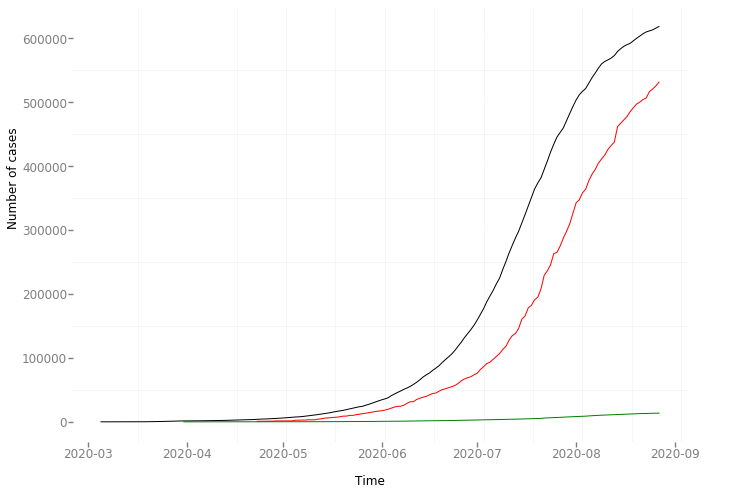

<ggplot: (127507598172)>

In [14]:
# plot the number of positive cases and recoveries
ggplot(total_cases, aes(x='date')) + \
    geom_line(aes(y='confirmed'), color='black') + \
    geom_line(aes(y='recoveries'), color='red') + \
    geom_line(aes(y='deaths'), color='green') + \
    xlab('Time') + \
    ylab('Number of cases') + \
    theme_bw()
# this graph still needs a legend

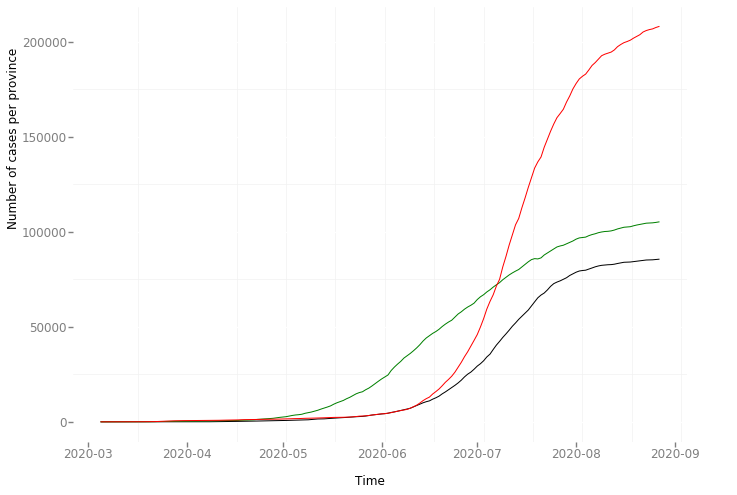

<ggplot: (127508988911)>

In [25]:
ggplot(confirmed, aes(x='date')) + \
    geom_line(aes(y='EC'), color='black') + \
    geom_line(aes(y='WC'), color='green') + \
    geom_line(aes(y='GP'), color='red') + \
    xlab('Time') + \
    ylab('Number of cases per province') + \
    theme_bw()

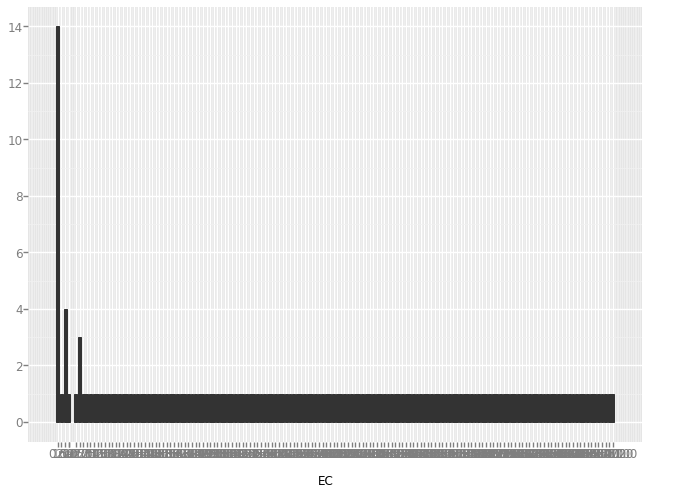

<ggplot: (-9223371888529560134)>

In [109]:
ggplot(aes('EC', ), data=confirmed) + \
    geom_bar()

In [106]:
total_cases['date'][0].month

3